In [29]:
import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option('display.max_colwidth', None)
#import os
#import re
import matplotlib.pyplot as plt
#import pickle
from IPython.display import display, Markdown
import seaborn as sns
from math import floor
import ast
import json
import re
import numpy as np

from dbmsbenchmarker import parameter, inspector

#import dbmsbenchmarker
#import bexhoma
from bexhoma import evaluators

%matplotlib inline

In [2]:
path = r"C:\data\benchmarks"
path = r"/home/perdelt/benchmarks"

In [9]:
def get_workload(code):
    with open(path+"/"+code+"/queries.config",'r') as inp:
        workload_properties = ast.literal_eval(inp.read())
        return workload_properties


def get_performance_single(evaluation):
    df = evaluation.get_df_benchmarking()
    df = df.sort_values(['experiment_run', 'client'])
    return df

def get_performance(evaluation):
    df = evaluation.get_df_benchmarking()
    df = df.sort_values(['experiment_run', 'client'])
    result = df.groupby('client').agg({
        'Goodput (requests/second)': 'sum',
        'num_errors': 'sum',
        'Latency Distribution.Average Latency (microseconds)': 'mean'
    }).reset_index()
    return result

def get_performance_all(codes):
    df_performance = pd.DataFrame()
    for code in codes:
        evaluation = evaluators.benchbase(code=code, path=path)
        workload = get_workload(code)
        df = get_performance(evaluation)
        df['type']=workload['tenant_per']
        df['num_tenants']=workload['num_tenants']
        #print(df)
        df_performance = pd.concat([df_performance, df])
    return df_performance

def get_performance_all_single(codes):
    df_performance = pd.DataFrame()
    for code in codes:
        evaluation = evaluators.benchbase(code=code, path=path)
        workload = get_workload(code)
        df = get_performance_single(evaluation)
        df['type']=workload['tenant_per']
        df['num_tenants']=workload['num_tenants']
        #print(df)
        df_performance = pd.concat([df_performance, df])
    return df_performance

def get_loading_time_max(evaluation):
    with open(path+"/"+evaluation.code+"/connections.config",'r') as inf:
        connections = ast.literal_eval(inf.read())
        pretty_connections = json.dumps(connections, indent=2)
        #print(pretty_connections)
        connections_sorted = sorted(connections, key=lambda c: c['name'])
        result = dict()
        for c in connections_sorted:
            result[c['name']] = {
                'time_load': c['timeLoad'],
                'time_ingest': c['timeIngesting'],
                'time_check': c['timeIndex'],
                #'terminals': c['parameter']['connection_parameter']['loading_parameters']['BENCHBASE_TERMINALS'],
                #'target': c['parameter']['connection_parameter']['loading_parameters']['BENCHBASE_TARGET'],
                'pods': c['parameter']['parallelism'],
                'tenant': c['parameter']['TENANT'] if 'TENANT' in c['parameter'] else '',
                'client': c['parameter']['client'],
                'datadisk': c['hostsystem']['datadisk'],
            }
            #result[c['parameter']['connection_parameter']['loading_parameters']['BENCHBASE_TERMINALS']] = c['timeIngesting']
        df = pd.DataFrame(result).T
        return df#df['time_load'].max()

def get_loading_time_max_all(codes):
    df_performance = pd.DataFrame()
    for code in codes:
        evaluation = evaluators.benchbase(code=code, path=path)
        workload = get_workload(code)
        df = get_loading_time_max(evaluation)
        df['type']=workload['tenant_per']
        df['num_tenants']=workload['num_tenants']
        #print(df)
        df_performance = pd.concat([df_performance, df])
    return df_performance

def show_summary_monitoring_table(evaluate, component):
    df_monitoring = list()
    ##########
    df = evaluate.get_monitoring_metric(metric='total_cpu_util_s', component=component)
    df = df.max().sort_index() - df.min().sort_index() # compute difference of counter
    #df = df.T.max().sort_index() - df.T.min().sort_index() # compute difference of counter
    df_cleaned = pd.DataFrame(df)
    df_cleaned.columns = ["CPU [CPUs]"]
    if not df_cleaned.empty:
        df_monitoring.append(df_cleaned.copy())
    ##########
    df = evaluate.get_monitoring_metric(metric='total_cpu_util', component=component)
    df = df.max().sort_index()
    df_cleaned = pd.DataFrame(df)
    df_cleaned.columns = ["Max CPU"]
    if not df_cleaned.empty:
        df_monitoring.append(df_cleaned.copy())
    ##########
    df = evaluate.get_monitoring_metric(metric='total_cpu_memory', component=component)/1024
    #df = evaluate.get_loading_metrics('total_cpu_memory')/1024
    df = df.max().sort_index()
    df_cleaned = pd.DataFrame(df).round(2)
    df_cleaned.columns = ["Max RAM [Gb]"]
    if not df_cleaned.empty:
        df_monitoring.append(df_cleaned.copy())
    ##########
    df = evaluate.get_monitoring_metric(metric='total_cpu_memory_cached', component=component)/1024
    #df = evaluate.get_loading_metrics('total_cpu_memory_cached')/1024
    df = df.max().sort_index()
    df_cleaned = pd.DataFrame(df)
    df_cleaned.columns = ["Max RAM Cached [Gb]"]
    if not df_cleaned.empty:
        df_monitoring.append(df_cleaned.copy())
    return df_monitoring

def get_monitoring_stream_single(evaluation):
    df_monitoring = show_summary_monitoring_table(evaluation, "stream")
    if len(df_monitoring) > 0:
        #print("\n### Stream SUT")
        df = pd.concat(df_monitoring, axis=1).round(2)
        df = df.reindex(index=evaluators.natural_sort(df.index))
        # If your DataFrame is named df and the index is a string like 'PostgreSQL-1-1-1024-0-1'
        df = df.copy()  # avoid modifying original
        df['client'] = df.index.str.rsplit('-', n=1).str[-1]
        #print(df)
        return df

def get_monitoring_stream(evaluation):
    df_monitoring = show_summary_monitoring_table(evaluation, "stream")
    if len(df_monitoring) > 0:
        #print("\n### Stream SUT")
        df = pd.concat(df_monitoring, axis=1).round(2)
        df = df.reindex(index=evaluators.natural_sort(df.index))
        # If your DataFrame is named df and the index is a string like 'PostgreSQL-1-1-1024-0-1'
        df = df.copy()  # avoid modifying original
        df['client'] = df.index.str.rsplit('-', n=1).str[-1]
        #print(df)
        result = df.groupby('client').agg({
            'CPU [CPUs]': 'sum',
            'Max RAM [Gb]': 'sum',
            'Max RAM Cached [Gb]': 'sum',
            'Max CPU': 'sum',
        }).reset_index()
        return result

def get_monitoring_stream_all(codes):
    df_performance = pd.DataFrame()
    for code in codes:
        evaluation = evaluators.benchbase(code=code, path=path)
        workload = get_workload(code)
        df = get_monitoring_stream(evaluation)
        df['type']=workload['tenant_per']
        df['num_tenants']=workload['num_tenants']
        #print(df)
        df_performance = pd.concat([df_performance, df])
    return df_performance


In [10]:
def sanitize_filename(title, max_length=100):
    # Replace non-alphanumeric characters with underscores
    safe = re.sub(r'[^a-zA-Z0-9-_]+', '_', title.strip())
    # Truncate to a safe length
    return safe[:max_length].rstrip('_')
    
def plot_bars(df, y, title, estimator):
    df_plot = df.copy()
    #df_plot = df_plot[df_plot['client']=='1']
    df_plot = df_plot.sort_values(['num_tenants','type'])
    # Hatch styles for each type
    hatch_map = {
        'container': '/',
        'database': '\\',
        'schema': 'x'
    }
    hue_order = ['container', 'database', 'schema']
    # Create the plot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        data=df_plot,
        x='num_tenants',
        y=y,
        hue='type',
        estimator=estimator,
        palette='Set2',
        hue_order=hue_order
    )
    for bar in ax.patches:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # X: center of bar
                height,                             # Y: top of bar
                f'{height:.1f}',                    # Text (1 decimal place)
                ha='center', va='bottom', fontsize=8
            )
    # Get tick positions (i.e., the x-axis categories)
    xticks = ax.get_xticks()
    bar_width = ax.patches[0].get_width()
    # Create a mapping from (num_tenants, type) to hatch
    grouped = df_plot.groupby(['num_tenants', 'type']).agg({y: estimator}).reset_index()
    #print(grouped)
    grouped_dict = {(row['num_tenants'], row['type']): hatch_map[row['type']] for _, row in grouped.iterrows()}
    bars = sorted(ax.patches, key=lambda bar: bar.get_x() if bar.get_height() > 0 else 10000)
    for bar, (_, row) in zip(bars, grouped.iterrows()):
        bar.my_id = (row['num_tenants'], row['type'])  # or anything else like an index or uuid
        bar.set_hatch(hatch_map[row['type']]) #grouped_dict[(bar.my_id)])
        bar.set_edgecolor('black')
        bar.set_linewidth(1)
    handles, labels = ax.get_legend_handles_labels()
    for handle, label in zip(handles, labels):
        hatch = hatch_map.get(label, '')
        handle.set_hatch(hatch)
    # Final touches
    plt.legend(title='Type')
    ax.legend(fontsize=18)
    #ax.legend(fontsize=18, loc='upper left', bbox_to_anchor=(1, 1))  # move outside
    plt.title(f"{title} by Number of Tenants and Type")
    plt.xlabel("Number of Tenants")
    plt.tight_layout()
    filename = "tpch_" + sanitize_filename(title) + ".png"    
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()



# Container

In [11]:
codes = [
    # container
    '1750860691', #tenants=1
    '1750862759', #tenants=2
    '1750865137', #tenants=3
    '1750867875', #tenants=4
    '1750870795', #tenants=5
    '1750874081', #tenants 6
    '1750877615', #tenants=7
    '1750881535', #tenants=8
    '1750885773', #tenants=9
    '1750890605', #tenants=10
    
    # database
    '1750860068', #tenants=1
    '1750862031', #tenants=2
    '1750864344', #tenants=3
    '1750866970', #tenants=4
    '1750869887', #tenants=5
    '1750873072', #tenants=6
    '1750876552', #tenants=7
    '1750880303', #tenants=8
    '1750884409', #tenants=9
    '1750889051', #tenants=10
    
    #schema
    '1750859440', #tenants=1
    '1750861312', #tenants=2
    '1750863504', #tenants=3
    '1750866067', #tenants=4
    '1750868888', #tenants=5
    '1750871956', #tenants=6   
    '1750875370', #tenants=7
    '1750879076', #tenants=8
    '1750883132', #tenants=9
    '1750887555', #tenants=10
]

In [6]:
df_performance = get_performance_all_single(codes)
df_performance.T

list index out of range
Traceback (most recent call last):
  File "/home/perdelt/anaconda3/envs/dbmsbenchmarker/lib/python3.11/site-packages/bexhoma/evaluators.py", line 1391, in log_to_df
    bench = re.findall('BENCHBASE_BENCH (.+?)\n', stdout)[0]
            ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^
IndexError: list index out of range

25.06.2025 14:17:44
BEXHOMA_CONNECTION:PostgreSQL-BHT-1-0-1
BEXHOMA_EXPERIMENT_RUN:1
BEXHOMA_CONFIGURATION:PostgreSQL-BHT-1-0
BEXHOMA_CLIENT:1
benchmark started at 2025-06-25 14:17:40
benchmark should wait until 0
ignore that start time
Querying message queue bexhoma-benchmarker-PostgreSQL-BHT-1-0-1-1750860691
Found entry number 1 in message queue.
BEXHOMA_TENANT_BY is not set
Querying counter bexhoma-benchmarker-podcount-PostgreSQL-BHT-1-0-1-1750860691
1
Found 1 / 1 running pods
PODS_RUNNING contains a number.
OK, found 1 ready pods.
Querying counter bexhoma-benchmarker-podcount-1750860691
1
Found 1 / 1 running pods
PODS_RUNNING contains a num

UnboundLocalError: cannot access local variable 'df_header' where it is not associated with a value

In [7]:
df_multi = df_performance.set_index(['num_tenants', 'type'])
df_multi

connection           configuration  \
num_tenants type                                                          
1           container  PostgreSQL-1-1-65536-0-1  PostgreSQL-1-1-65536-0   
            container  PostgreSQL-1-1-65536-0-2  PostgreSQL-1-1-65536-0   
2           container  PostgreSQL-1-1-65536-1-1  PostgreSQL-1-1-65536-1   
            container  PostgreSQL-1-1-65536-0-1  PostgreSQL-1-1-65536-0   
            container  PostgreSQL-1-1-65536-0-2  PostgreSQL-1-1-65536-0   
            container  PostgreSQL-1-1-65536-1-2  PostgreSQL-1-1-65536-1   
3           container  PostgreSQL-1-1-65536-0-1  PostgreSQL-1-1-65536-0   
            container  PostgreSQL-1-1-65536-2-1  PostgreSQL-1-1-65536-2   
            container  PostgreSQL-1-1-65536-1-1  PostgreSQL-1-1-65536-1   
            container  PostgreSQL-1-1-65536-0-2  PostgreSQL-1-1-65536-0   
            container  PostgreSQL-1-1-65536-2-2  PostgreSQL-1-1-65536-2   
            container  PostgreSQL-1-1-65536-1-2  PostgreSQL-1-1-65536-1   
4           container  PostgreSQL-1-1-65536-2-1  PostgreSQL-1-1-65536-2   
            container  PostgreSQL-1-1-65536-1-1  PostgreSQL-1-1-65536-1   
            container  PostgreSQL-1-1-65536-3-1  PostgreSQL-1-1-65536-3   
            container  PostgreSQL-1-1-65536-0-1  PostgreSQL-1-1-65536-0   
            container  PostgreSQL-1-1-65536-2-2  PostgreSQL-1-1-65536-2   
            container  PostgreSQL-1-1-65536-1-2  PostgreSQL-1-1-65536-1   
            container  PostgreSQL-1-1-65536-3-2  PostgreSQL-1-1-65536-3   
            container  PostgreSQL-1-1-65536-0-2  PostgreSQL-1-1-65536-0   
5           container  PostgreSQL-1-1-65536-4-1  PostgreSQL-1-1-65536-4   
            container  PostgreSQL-1-1-65536-1-1  PostgreSQL-1-1-65536-1   
            container  PostgreSQL-1-1-65536-2-1  PostgreSQL-1-1-65536-2   
            container  PostgreSQL-1-1-65536-3-1  PostgreSQL-1-1-65536-3   
            container  PostgreSQL-1-1-65536-0-1  PostgreSQL-1-1-65536-0   
            container  PostgreSQL-1-1-65536-4-2  PostgreSQL-1-1-65536-4   
            container  PostgreSQL-1-1-65536-0-2  PostgreSQL-1-1-65536-0   
            container  PostgreSQL-1-1-65536-2-2  PostgreSQL-1-1-65536-2   
            container  PostgreSQL-1-1-65536-3-2  PostgreSQL-1-1-65536-3   
            container  PostgreSQL-1-1-65536-1-2  PostgreSQL-1-1-65536-1   
6           container  PostgreSQL-1-1-65536-2-1  PostgreSQL-1-1-65536-2   
            container  PostgreSQL-1-1-65536-5-1  PostgreSQL-1-1-65536-5   
            container  PostgreSQL-1-1-65536-0-1  PostgreSQL-1-1-65536-0   
            container  PostgreSQL-1-1-65536-4-1  PostgreSQL-1-1-65536-4   
            container  PostgreSQL-1-1-65536-3-1  PostgreSQL-1-1-65536-3   
            container  PostgreSQL-1-1-65536-1-1  PostgreSQL-1-1-65536-1   
            container  PostgreSQL-1-1-65536-5-2  PostgreSQL-1-1-65536-5   
            container  PostgreSQL-1-1-65536-2-2  PostgreSQL-1-1-65536-2   
            container  PostgreSQL-1-1-65536-1-2  PostgreSQL-1-1-65536-1   
            container  PostgreSQL-1-1-65536-0-2  PostgreSQL-1-1-65536-0   
            container  PostgreSQL-1-1-65536-3-2  PostgreSQL-1-1-65536-3   
            container  PostgreSQL-1-1-65536-4-2  PostgreSQL-1-1-65536-4   
7           container  PostgreSQL-1-1-65536-3-1  PostgreSQL-1-1-65536-3   
            container  PostgreSQL-1-1-65536-1-1  PostgreSQL-1-1-65536-1   
            container  PostgreSQL-1-1-65536-4-1  PostgreSQL-1-1-65536-4   
            container  PostgreSQL-1-1-65536-0-1  PostgreSQL-1-1-65536-0   
            container  PostgreSQL-1-1-65536-5-1  PostgreSQL-1-1-65536-5   
            container  PostgreSQL-1-1-65536-2-1  PostgreSQL-1-1-65536-2   
            container  PostgreSQL-1-1-65536-6-1  PostgreSQL-1-1-65536-6   
            container  PostgreSQL-1-1-65536-5-2  PostgreSQL-1-1-65536-5   
            container  PostgreSQL-1-1-65536-4-2  PostgreSQL-1-1-65536-4   
            container  PostgreSQL-1-1-65536-0-2  PostgreSQL-1-

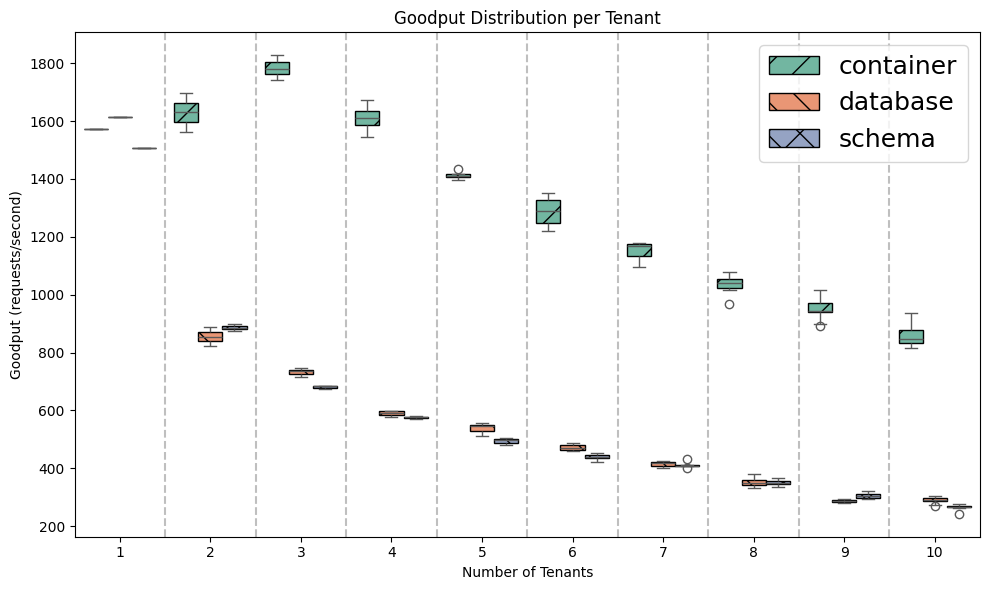

In [8]:
df = df_performance[df_performance['client']=='1']
#df = df_performance.copy()

plt.figure(figsize=(10, 6))
# Hatch styles for each type
hatch_map = {
    'container': '/',
    'database': '\\',
    'schema': 'x'
}
hue_order = ['container', 'database', 'schema']

# Plot boxplots grouped by num_tenants and colored by type
ax = sns.boxplot(
    data=df,
    x='num_tenants',
    y='Goodput (requests/second)',
    hue='type',
    palette='Set2'  # consistent colors per type
)
# Add vertical separator lines between groups
# Get the number of unique num_tenants and type
num_groups = df['num_tenants'].nunique()
num_types = df['type'].nunique()

# Extract hue order
hue_order = ax.get_legend_handles_labels()[1]
num_hue = len(hue_order)

# Get hue order from seaborn (types)
_, type_order = ax.get_legend_handles_labels()
num_types = len(type_order)

#print(len(ax.patches))
# Set hatches correctly: patches are grouped by x then by hue
for i, patch in enumerate(ax.patches):
    #print(i)
    type_index = i // (num_groups)
    if type_index >= num_types:
        break
    type_name = type_order[type_index]
    patch.set_hatch(hatch_map.get(type_name, ''))
    #print(hatch_map.get(type_name, ''))
    patch.set_edgecolor('black')
    patch.set_linewidth(1)

# Each num_tenants group has num_types boxes
for i in range(1, num_groups):
    xpos = i - 0.5 #0.5
    ax.axvline(x=xpos, color='gray', linestyle='--', alpha=0.5)


# Update legend with matching hatches
handles, labels = ax.get_legend_handles_labels()
for handle, label in zip(handles, labels):
    hatch = hatch_map.get(label, '')
    handle.set_hatch(hatch)
    handle.set_edgecolor('black')
    handle.set_linewidth(1)

plt.title("Goodput Distribution per Tenant")
plt.xlabel("Number of Tenants")
plt.ylabel("Goodput (requests/second)")
plt.legend(title="Type")
ax.legend(fontsize=18)
plt.tight_layout()
plt.show()

In [9]:
df_performance = get_performance_all(codes)
df_performance

,client,Goodput (requests/second),num_errors,Latency Distribution.Average Latency (microseconds),type,num_tenants
0,1,1573.971516,6,62914.000000,container,1
1,2,3752.529821,43,26257.000000,container,1
0,1,3259.649810,30,60789.500000,container,2
1,2,6690.324652,97,29462.000000,container,2
0,1,5349.228066,71,55429.000000,container,3
1,2,8393.221526,136,35217.333333,container,3
0,1,6434.534533,84,61425.000000,container,4
1,2,9456.329515,180,41651.750000,container,4
0,1,7067.734660,86,69814.400000,container,5
1,2,9906.644639,164,49688.200000,container,5


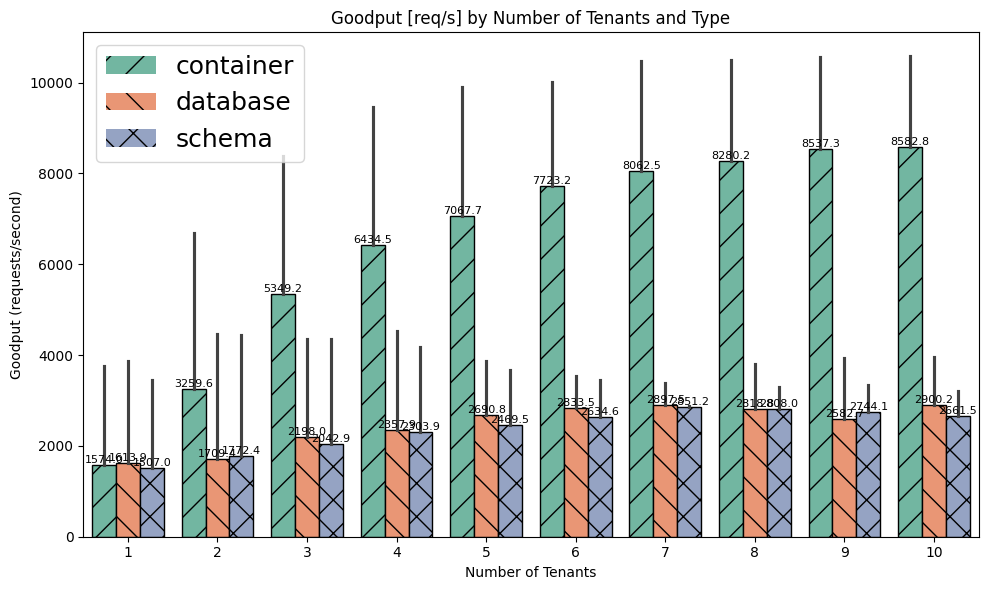

In [10]:
plot_bars(df_performance, y='Goodput (requests/second)', title='Goodput [req/s]', estimator='min')

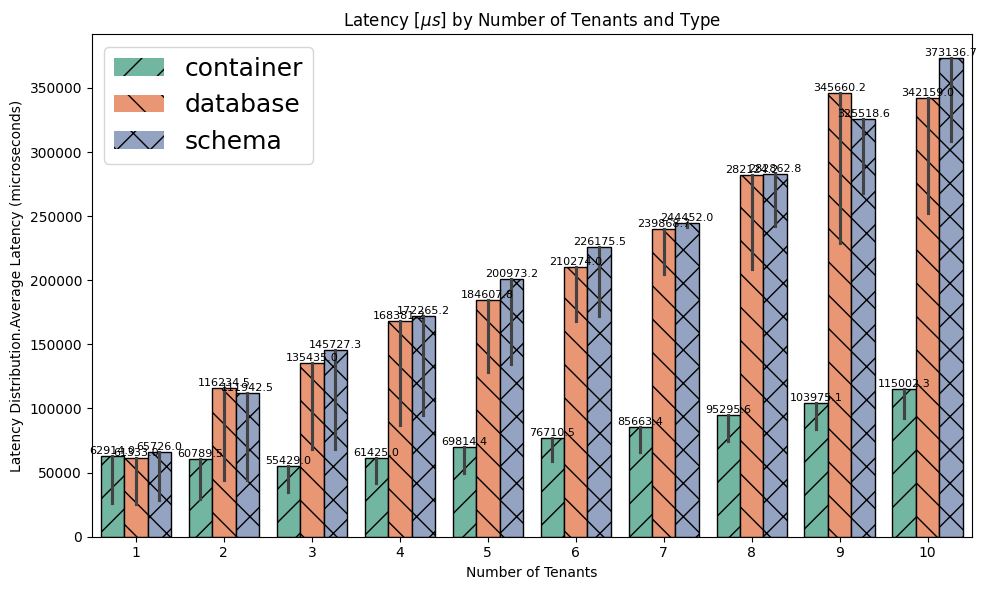

In [11]:
plot_bars(df_performance, y='Latency Distribution.Average Latency (microseconds)', title='Latency [$\mu s$]', estimator='max')

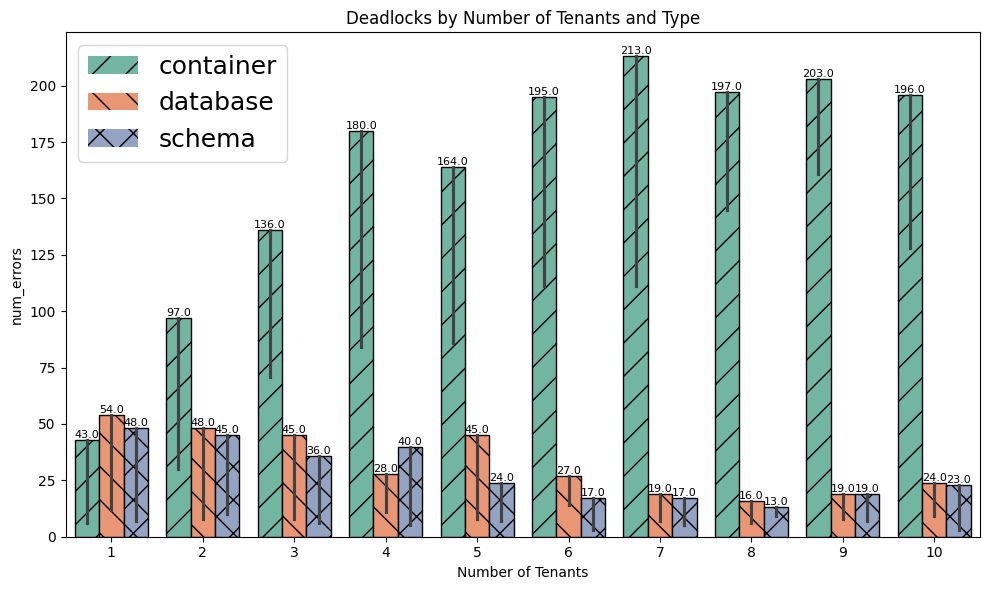

In [12]:
plot_bars(df_performance, y='num_errors', title='Deadlocks', estimator='max')

In [12]:
df_performance = get_loading_time_max_all(codes)
df_performance

,time_load,time_ingest,time_check,pods,tenant,client,datadisk,type,num_tenants
PostgreSQL-BHT-1-0-1-1,315.0,104.0,209.0,1,0,1,2757,container,1
PostgreSQL-BHT-1-0-2-1,315.0,104.0,209.0,1,0,2,2757,container,1
PostgreSQL-BHT-1-0-1-1,325.0,105.0,216.0,1,0,1,2757,container,2
PostgreSQL-BHT-1-0-2-1,325.0,105.0,216.0,1,0,2,2757,container,2
PostgreSQL-BHT-1-1-1-1,327.0,107.0,217.0,1,1,1,2757,container,2
PostgreSQL-BHT-1-1-2-1,327.0,107.0,217.0,1,1,2,2757,container,2
PostgreSQL-BHT-1-0-1-1,312.0,89.0,216.0,1,0,1,2757,container,3
PostgreSQL-BHT-1-0-2-1,312.0,89.0,216.0,1,0,2,2757,container,3
PostgreSQL-BHT-1-1-1-1,311.0,89.0,216.0,1,1,1,2757,container,3
PostgreSQL-BHT-1-1-2-1,311.0,89.0,216.0,1,1,2,2757,container,3


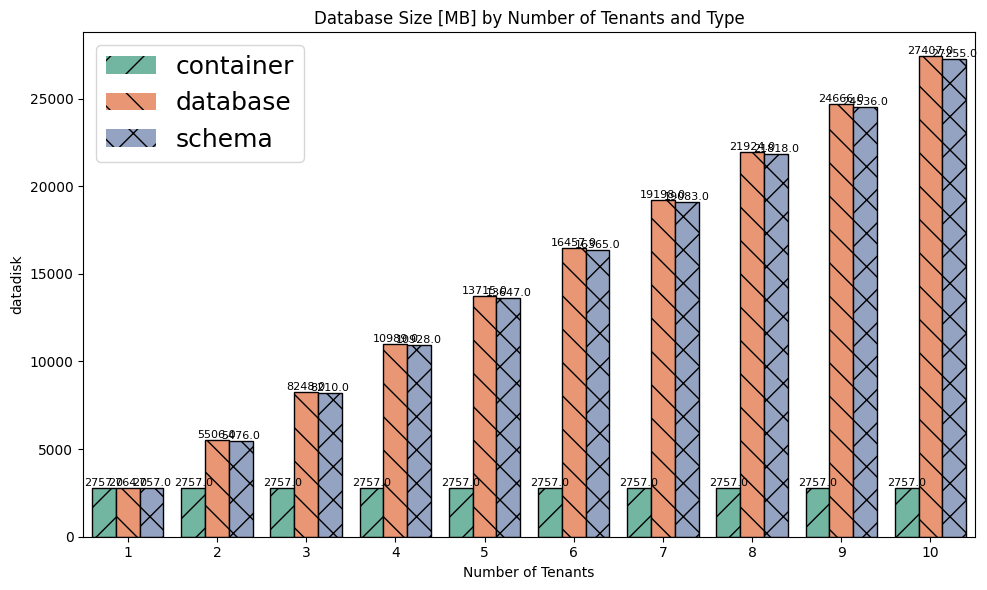

In [18]:
df_performance_first = df_performance[df_performance['client'] == '1']
plot_bars(df_performance_first, y='datadisk', title='Database Size [MB]', estimator='max')

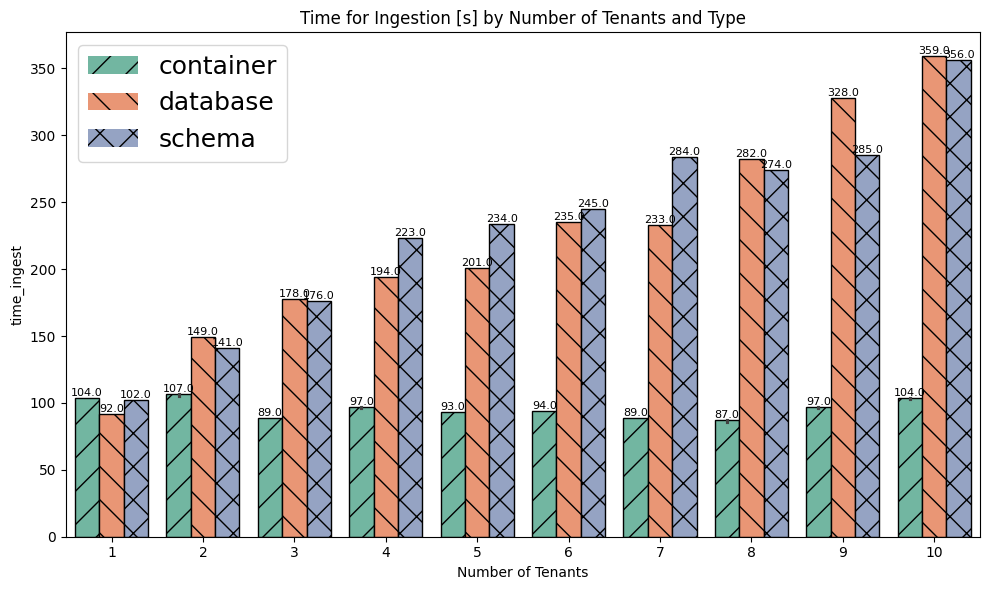

In [19]:
plot_bars(df_performance, y='time_ingest', title='Time for Ingestion [s]', estimator='max')

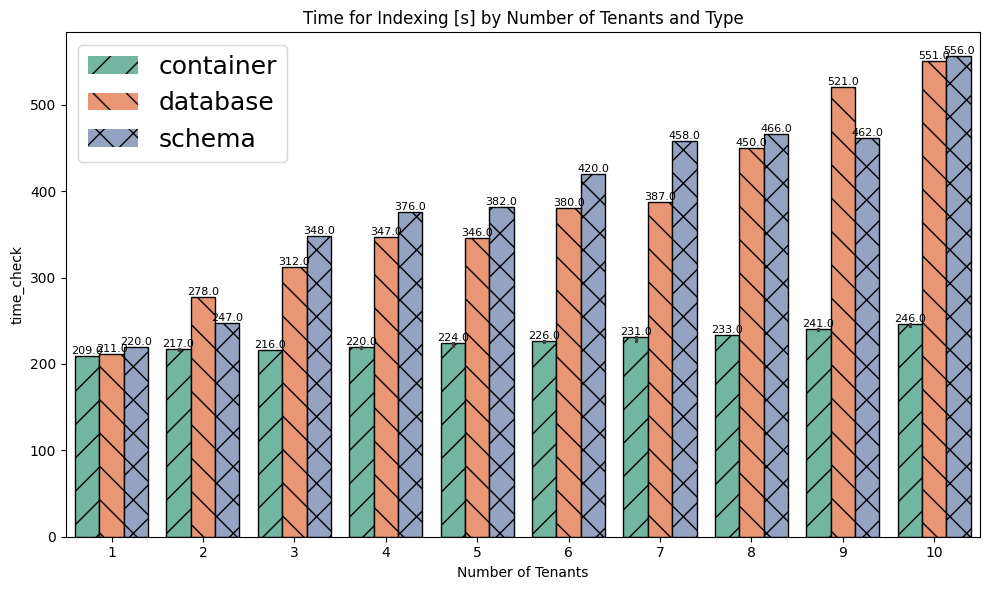

In [21]:
plot_bars(df_performance, y='time_check', title='Time for Indexing [s]', estimator='max')

In [23]:
df_performance = get_monitoring_stream_all(codes)
df_performance = df_performance[df_performance['client'] == '1']
df_performance

,client,CPU [CPUs],Max RAM [Gb],Max RAM Cached [Gb],Max CPU,type,num_tenants
0,1,88.96,3.75,5.38,1.60,container,1
0,1,162.57,11.00,14.24,0.00,container,2
0,1,149.85,11.13,16.00,2.64,container,3
0,1,274.91,15.08,21.56,2.33,container,4
0,1,590.60,19.05,27.15,6.52,container,5
0,1,580.74,22.68,32.62,3.55,container,6
0,1,901.66,26.67,38.01,4.53,container,7
0,1,1021.32,30.26,43.24,8.40,container,8
0,1,1371.40,34.35,48.93,5.59,container,9
0,1,1464.75,38.03,54.23,8.32,container,10


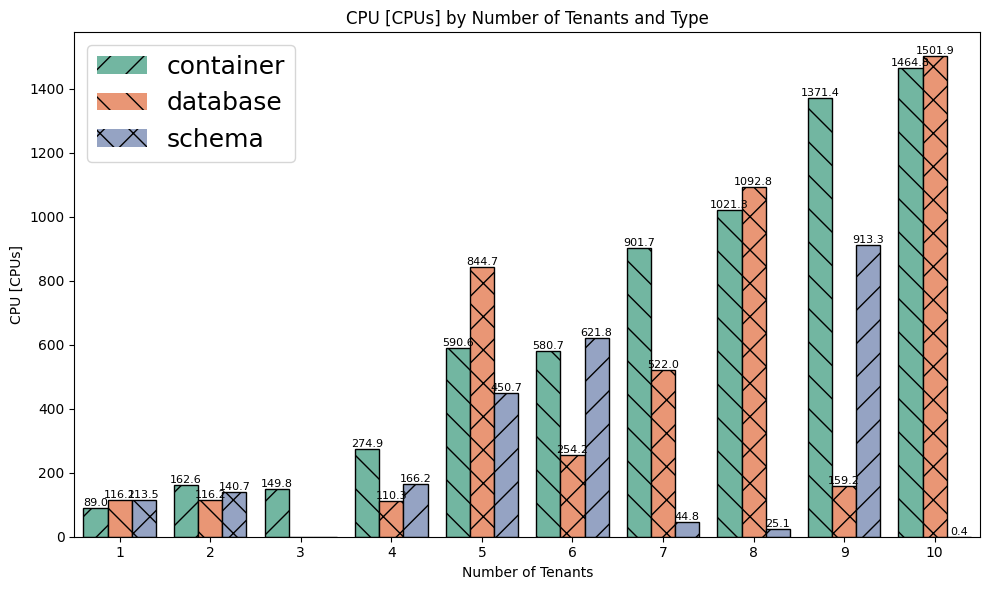

In [24]:
plot_bars(df_performance, y='CPU [CPUs]', title='CPU [CPUs]', estimator='max')

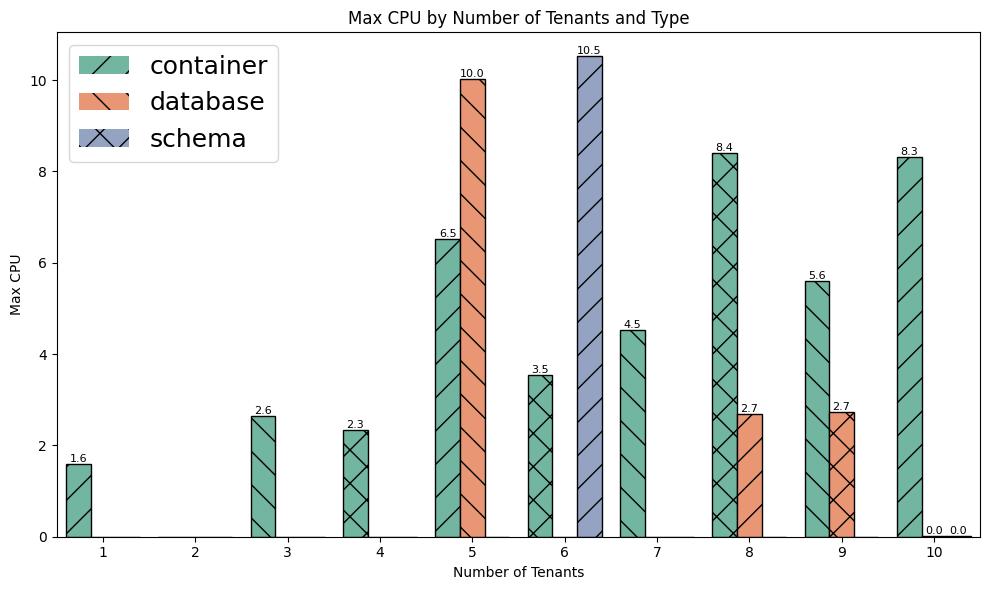

In [25]:
plot_bars(df_performance, y='Max CPU', title='Max CPU', estimator='sum')

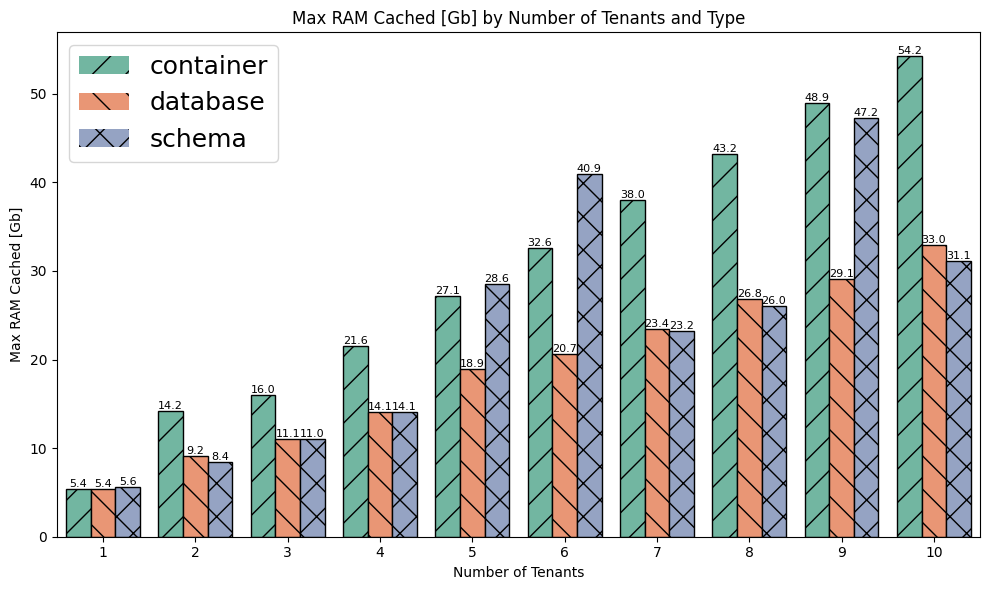

In [26]:
plot_bars(df_performance, y='Max RAM Cached [Gb]', title='Max RAM Cached [Gb]', estimator='sum')

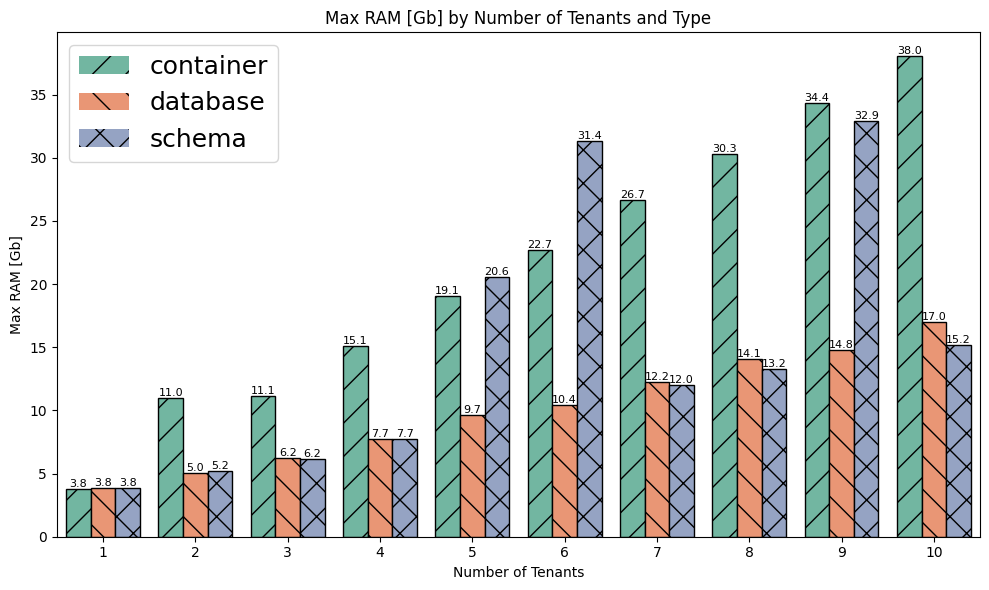

In [27]:
plot_bars(df_performance, y='Max RAM [Gb]', title='Max RAM [Gb]', estimator='sum')

# Single Experiment

In [21]:
code = '1750741356'
evaluation = evaluators.benchbase(code=code, path=path)
workload = get_workload(code)

In [22]:
df=get_performance_single(evaluation)
df['type']=workload['tenant_per']
df['num_tenants']=workload['num_tenants']
df.T

connection_pod,PostgreSQL-1-1-16384-1-1,PostgreSQL-1-1-16384-1-2,PostgreSQL-1-1-16384-1-3,PostgreSQL-1-1-16384-1-4,PostgreSQL-1-1-16384-1-5,PostgreSQL-1-1-16384-1-6,PostgreSQL-1-1-16384-1-7,PostgreSQL-1-1-16384-1-8,PostgreSQL-1-1-16384-1-9,PostgreSQL-1-1-16384-2-1,PostgreSQL-1-1-16384-2-2,PostgreSQL-1-1-16384-2-3,PostgreSQL-1-1-16384-2-4,PostgreSQL-1-1-16384-2-5,PostgreSQL-1-1-16384-2-6,PostgreSQL-1-1-16384-2-7,PostgreSQL-1-1-16384-2-8,PostgreSQL-1-1-16384-2-9
connection,PostgreSQL-1-1-16384-1,PostgreSQL-1-1-16384-1,PostgreSQL-1-1-16384-1,PostgreSQL-1-1-16384-1,PostgreSQL-1-1-16384-1,PostgreSQL-1-1-16384-1,PostgreSQL-1-1-16384-1,PostgreSQL-1-1-16384-1,PostgreSQL-1-1-16384-1,PostgreSQL-1-1-16384-2,PostgreSQL-1-1-16384-2,PostgreSQL-1-1-16384-2,PostgreSQL-1-1-16384-2,PostgreSQL-1-1-16384-2,PostgreSQL-1-1-16384-2,PostgreSQL-1-1-16384-2,PostgreSQL-1-1-16384-2,PostgreSQL-1-1-16384-2
configuration,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384
experiment_run,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
client,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2
pod,v8pgd.dbmsbenchmarker,bzrfv.dbmsbenchmarker,tqj89.dbmsbenchmarker,sk5cz.dbmsbenchmarker,5whq6.dbmsbenchmarker,h4z87.dbmsbenchmarker,9l5dp.dbmsbenchmarker,tdpzd.dbmsbenchmarker,jrbdr.dbmsbenchmarker,pwlbg.dbmsbenchmarker,f9gzm.dbmsbenchmarker,zkgfb.dbmsbenchmarker,nz6tc.dbmsbenchmarker,8c249.dbmsbenchmarker,n6x9k.dbmsbenchmarker,s6j9t.dbmsbenchmarker,gq2mn.dbmsbenchmarker,xbjz6.dbmsbenchmarker
pod_count,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9
bench,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc
profile,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres
target,16384,16384,16384,16384,16384,16384,16384,16384,16384,16384,16384,16384,16384,16384,16384,16384,16384,16384
time,600,600,600,600,600,600,600,600,600,600,600,600,600,600,600,600,600,600


In [23]:
get_loading_time_max(evaluation)

,time_load,time_ingest,time_check,terminals,pods,tenant,client,datadisk
PostgreSQL-1-1-16384-1,1149.0,526.0,615.0,1,9,,1,24232
PostgreSQL-1-1-16384-2,1149.0,526.0,615.0,1,9,,2,36837


In [24]:
get_monitoring_stream_single(evaluation).sort_values('client')

,CPU [CPUs],Max CPU,Max RAM [Gb],Max RAM Cached [Gb],client
PostgreSQL-1-1-16384-1,19066.36,41.08,29.02,40.21,1
PostgreSQL-1-1-16384-2,23623.90,50.35,32.22,45.44,2


In [25]:
get_monitoring_stream(evaluation)

,client,CPU [CPUs],Max RAM [Gb],Max RAM Cached [Gb],Max CPU
0,1,19066.36,29.02,40.21,41.08
1,2,23623.90,32.22,45.44,50.35


In [34]:
code=codes[9]
evaluate = inspector.inspector(path)
evaluate.load_experiment(code=code, silent=True)
query_properties = evaluate.get_experiment_query_properties()
query_properties

{'1': {'config': {'title': 'Pricing Summary Report (TPC-H Q1)',
   'query': "select\nl_returnflag,\nl_linestatus,\ncast(sum(l_quantity) as bigint) as sum_qty,\nsum(l_extendedprice) as sum_base_price,\nsum(l_extendedprice*(1-l_discount)) as sum_disc_price,\nsum(l_extendedprice*(1-l_discount)*(1+l_tax)) as sum_charge,\navg(l_quantity) as avg_qty,\navg(l_extendedprice) as avg_price,\navg(l_discount) as avg_disc,\ncount(*) as count_order\nfrom\nlineitem\nwhere\nl_shipdate <= date '1998-12-01' - interval '{DELTA}'  day\ngroup by\nl_returnflag,\nl_linestatus\norder by\nl_returnflag,\nl_linestatus",
   'DBMS': {'MySQL': "select\nl_returnflag,\nl_linestatus,\ncast(sum(l_quantity) as unsigned int) as sum_qty,\nsum(l_extendedprice) as sum_base_price,\nsum(l_extendedprice*(1-l_discount)) as sum_disc_price,\nsum(l_extendedprice*(1-l_discount)*(1+l_tax)) as sum_charge,\navg(l_quantity) as avg_qty,\navg(l_extendedprice) as avg_price,\navg(l_discount) as avg_disc,\ncount(*) as count_order\nfrom\nline

In [37]:
print("\n### Power@Size ((3600*SF)/(geo times))")
df = evaluate.get_aggregated_experiment_statistics(type='timer', name='execution', query_aggregate='Median', total_aggregate='Geo')
df = (df/1000.0).sort_index().astype('float')
df = float(parameter.defaultParameters['SF'])*3600./df
df.columns = ['Power@Size [~Q/h]']
df_power = df.copy()
print(df.round(2))



### Power@Size ((3600*SF)/(geo times))
                        Power@Size [~Q/h]
DBMS                                     
PostgreSQL-BHT-1-0-1-1            3457.17
PostgreSQL-BHT-1-0-2-1            3483.59
PostgreSQL-BHT-1-1-1-1            3490.43
PostgreSQL-BHT-1-1-2-1            3405.09
PostgreSQL-BHT-1-2-1-1            3465.02
PostgreSQL-BHT-1-2-2-1            3423.04
PostgreSQL-BHT-1-3-1-1            3411.87
PostgreSQL-BHT-1-3-2-1            3384.33
PostgreSQL-BHT-1-4-1-1            3503.92
PostgreSQL-BHT-1-4-2-1            3416.11
PostgreSQL-BHT-1-5-1-1            3459.40
PostgreSQL-BHT-1-5-2-1            3450.29
PostgreSQL-BHT-1-6-1-1            3489.08
PostgreSQL-BHT-1-6-2-1            3481.17
PostgreSQL-BHT-1-7-1-1            3429.21
PostgreSQL-BHT-1-7-2-1            3510.42
PostgreSQL-BHT-1-8-1-1            3486.70
PostgreSQL-BHT-1-8-2-1            3431.86
PostgreSQL-BHT-1-9-1-1            3488.31
PostgreSQL-BHT-1-9-2-1            3399.32


In [38]:
print("\n### Geometric Mean of Medians of Timer Run [s]")
df = evaluate.get_aggregated_experiment_statistics(type='timer', name='run', query_aggregate='Median', total_aggregate='Geo')
df = (df/1000.0).sort_index()
df.columns = ['Geo Times [s]']
df_geo_mean_runtime = df.copy()
print(df.round(2))



### Geometric Mean of Medians of Timer Run [s]
                        Geo Times [s]
DBMS                                 
PostgreSQL-BHT-1-0-1-1           1.04
PostgreSQL-BHT-1-0-2-1           1.03
PostgreSQL-BHT-1-1-1-1           1.03
PostgreSQL-BHT-1-1-2-1           1.06
PostgreSQL-BHT-1-2-1-1           1.04
PostgreSQL-BHT-1-2-2-1           1.05
PostgreSQL-BHT-1-3-1-1           1.06
PostgreSQL-BHT-1-3-2-1           1.06
PostgreSQL-BHT-1-4-1-1           1.03
PostgreSQL-BHT-1-4-2-1           1.05
PostgreSQL-BHT-1-5-1-1           1.04
PostgreSQL-BHT-1-5-2-1           1.04
PostgreSQL-BHT-1-6-1-1           1.03
PostgreSQL-BHT-1-6-2-1           1.03
PostgreSQL-BHT-1-7-1-1           1.05
PostgreSQL-BHT-1-7-2-1           1.03
PostgreSQL-BHT-1-8-1-1           1.03
PostgreSQL-BHT-1-8-2-1           1.05
PostgreSQL-BHT-1-9-1-1           1.03
PostgreSQL-BHT-1-9-2-1           1.06
